# Utilities

### Load Data

In [1530]:
%load_ext autoreload
%autoreload 2

# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

from etl.extract import ProjectZero

# import projectzero data
from etl.extract import ProjectZero
data = ProjectZero().get_data()

# df_model instance
df_model = data['hz_model'].copy()
df_nyc = data['ext_nyc']
df_seattle = data['ext_seattle'].copy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\hramzan\Documents\GitHub\project_zero\etl\extract.py:24: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



### Feature Engineering

In [1531]:
for i in list(df_nyc.columns):
    print(i)

Unnamed: 0
Order
Property Id
Property Name
Parent Property Id
Parent Property Name
BBL - 10 digits
NYC Borough, Block and Lot (BBL) self-reported
NYC Building Identification Number (BIN)
Address 1 (self-reported)
Address 2 (self-reported)
Postal Code
Street Number
Street Name
Borough
DOF Gross Floor Area (ft²)
Self-Reported Gross Floor Area (ft²)
Primary Property Type - Self Selected
List of All Property Use Types at Property
Largest Property Use Type
Largest Property Use Type - Gross Floor Area (ft²)
2nd Largest Property Use Type
2nd Largest Property Use - Gross Floor Area (ft²)
3rd Largest Property Use Type
3rd Largest Property Use Type - Gross Floor Area (ft²)
Year Built
Number of Buildings
Occupancy
Metered Areas (Energy)
Metered Areas  (Water)
ENERGY STAR Score
Source EUI (kBtu/ft²)
Weather Normalized Source EUI (kBtu/ft²)
Site EUI (kBtu/ft²)
Weather Normalized Site EUI (kBtu/ft²)
Weather Normalized Site Electricity Intensity (kWh/ft²)
Weather Normalized Site Natural Gas Intensity

In [1532]:
for i in list(df_seattle.columns):
    print(i)

OSEBuildingID
DataYear
BuildingType
PrimaryPropertyType
PropertyName
TaxParcelIdentificationNumber
Location
CouncilDistrictCode
Neighborhood
YearBuilt
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
OtherFuelUse(kBtu)
GHGEmissions(MetricTonsCO2e)
GHGEmissionsIntensity(kgCO2e/ft2)
DefaultData
Comment
ComplianceStatus
Outlier
2010 Census Tracts
Seattle Police Department Micro Community Policing Plan Areas
City Council Districts
SPD Beats
Zip Codes


In [1533]:
features = [
    'PrimaryPropertyType',
    'NumberofFloors',
    'PropertyGFABuilding(s)',
    'PropertyGFAParking',
    'YearBuilt',
    'BuildingType',
    'Electricity(kWh)']

df_seattle = df_seattle[features]

# drop duplicates
df_seattle.dropna(inplace=True)

high_correlation = [
    'Hotel',
    'Low-Rise Multifamily',
    'Mid-Rise Multifamily',
    'High-Rise Multifamily',
    'K-12 School',
    'College/University',
    'Large Office',
    'Retail Store'
    ]

# filter to show only those with high correlations
df_seattle = df_seattle[df_seattle.PrimaryPropertyType.isin(high_correlation)] 

# Removing outliers for 'College/University' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'College/University') & (df_seattle['PropertyGFABuilding(s)'] >= 2200000))]

# Removing outliers for 'Retail Store' from the original DataFrame
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'Retail Store') & (df_seattle['PropertyGFABuilding(s)'] >= 200000))]

# drop extremely large buildings
df_seattle = df_seattle[~((df_seattle['Electricity(kWh)'] > 6000000) | (df_seattle['PropertyGFABuilding(s)'] > 800000))]

#high rise outliers
df_seattle = df_seattle[~((df_seattle['PrimaryPropertyType'] == 'High-Rise Multifamily') & (df_seattle['Electricity(kWh)'] >= 5000000))]


In [1534]:
# feature engineer average floor area
df_seattle['avg_floor_area'] = df_seattle['PropertyGFABuilding(s)'] / df_seattle.NumberofFloors

# feature engineer binary resi and non resi
# change building type to binary value (residential and non resi)
building_type = lambda x: 'residential' if x != 'NonResidential' else 'non_residential'
df_seattle['building_classification'] =  df_seattle['BuildingType'].map(building_type)
df_seattle.drop(columns='BuildingType', inplace=True)


In [1535]:
import plotly.express as px

px.scatter(df_seattle, x='PropertyGFABuilding(s)', y='Electricity(kWh)', color='PrimaryPropertyType')


### Encoding & scaling

In [1536]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output= False) 

# Fit encoder
ohe.fit(df_seattle[['PrimaryPropertyType']])

# Transform the current "Street" column
df_seattle[ohe.get_feature_names_out()] = ohe.transform(df_seattle[['PrimaryPropertyType']])

# Drop the column "Street" which has been encoded
df_seattle.drop(columns = ['PrimaryPropertyType'], inplace = True)

df_seattle

,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,YearBuilt,Electricity(kWh),avg_floor_area,building_classification,PrimaryPropertyType_College/University,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Retail Store
0,12.0,88434,0,1927,1080307.0,7369.500000,non_residential,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,11.0,88502,15064,1996,1144563.0,8045.636364,non_residential,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10.0,61320,0,1926,811521.0,6132.000000,non_residential,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,18.0,107430,12460,1980,1777841.0,5968.333333,non_residential,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,11.0,83008,0,1926,785342.0,7546.181818,non_residential,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,4.0,44650,0,2000,334979.0,11162.500000,residential,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3336,7.0,42393,0,2014,325705.0,6056.142857,residential,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3337,40.0,277566,41915,2015,1690364.0,6939.150000,residential,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3338,3.0,48230,0,1981,227744.0,16076.666667,residential,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [1537]:
from sklearn.preprocessing import OrdinalEncoder

# finding string features to encode
nan_features = [i for i in df_seattle.columns if df_seattle[i].dtype == 'object']

# Instantiate Ordinal Encoder
ordinal_encoder = OrdinalEncoder()

# Fit to features
df_encoded = df_seattle.copy()
ordinal_encoder.fit(df_encoded[nan_features])

# Transforming categories into ordered numbers
df_encoded[nan_features] = ordinal_encoder.transform(df_encoded[nan_features])
df_encoded.head(3)



,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,YearBuilt,Electricity(kWh),avg_floor_area,building_classification,PrimaryPropertyType_College/University,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Retail Store
0,12.0,88434,0,1927,1080307.0,7369.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,11.0,88502,15064,1996,1144563.0,8045.636364,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10.0,61320,0,1926,811521.0,6132.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1538]:
from sklearn.preprocessing import StandardScaler

# drop property type columns
# df_seattle.drop(columns='PrimaryPropertyType', inplace=True)

# instantiate scaler
s_scaler = StandardScaler()

# instantiate scaled df before transform
df_scaled = df_encoded.copy()

# define numerical features 
numerical_features = list(df_scaled.columns)
numerical_features.remove('Electricity(kWh)') # remove target before scaling

# fit scaler
s_scaler.fit(df_scaled[numerical_features])

# apply tranform to features
df_scaled[numerical_features] = s_scaler.transform(df_scaled[numerical_features])
df_scaled.head(3)

,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,YearBuilt,Electricity(kWh),avg_floor_area,building_classification,PrimaryPropertyType_College/University,PrimaryPropertyType_High-Rise Multifamily,PrimaryPropertyType_Hotel,PrimaryPropertyType_K-12 School,PrimaryPropertyType_Large Office,PrimaryPropertyType_Low-Rise Multifamily,PrimaryPropertyType_Mid-Rise Multifamily,PrimaryPropertyType_Retail Store
0,1.587412,0.271982,-0.392780,-1.377334,1080307.0,-0.462773,-2.237364,-0.090953,-0.224003,5.428682,-0.25873,-0.25979,-0.961178,-0.592957,-0.21678
1,1.355228,0.272944,0.219278,0.739801,1144563.0,-0.426804,-2.237364,-0.090953,-0.224003,5.428682,-0.25873,-0.25979,-0.961178,-0.592957,-0.21678
3,1.123044,-0.111498,-0.392780,-1.408017,811521.0,-0.528605,-2.237364,-0.090953,-0.224003,5.428682,-0.25873,-0.25979,-0.961178,-0.592957,-0.21678


In [1539]:
# can define as l1, l2, or none (automatically defualts to l2)
from sklearn.linear_model import LogisticRegression

X = df_scaled[numerical_features]
y = df_scaled['Electricity(kWh)']

l2_model = LogisticRegression(penalty='l2', solver='liblinear') 
l2_model.fit(X, y)

l2_coefficients = l2_model.coef_[0]
l2_features = X.columns

# Display features and corresponding coefficients
coefficients_l2 = pd.DataFrame({'Feature': l2_features, 'Coefficient': l2_coefficients})

coefficients_l2.sort_values('Coefficient', inplace=True)
coefficients_l2

,Feature,Coefficient
7,PrimaryPropertyType_High-Rise Multifamily,-0.249073
3,YearBuilt,-0.225818
1,PropertyGFABuilding(s),-0.134473
8,PrimaryPropertyType_Hotel,-0.121921
5,building_classification,-0.079066
2,PropertyGFAParking,-0.076254
12,PrimaryPropertyType_Mid-Rise Multifamily,-0.035314
6,PrimaryPropertyType_College/University,-0.016705
11,PrimaryPropertyType_Low-Rise Multifamily,-0.008153
9,PrimaryPropertyType_K-12 School,0.011915


### Train Model and Predict

In [1540]:
# import model type
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Instantiate model 
sgd_regressor = SGDRegressor(random_state=1, alpha=0.1)

# define x and y 
features = list(df_scaled.columns)
features.remove('Electricity(kWh)')

X = df_scaled[features]
y = df_scaled['Electricity(kWh)']

# train model 

scores = cross_val_score(sgd_regressor, X, y, cv=3)
scores.mean()

0.715702952204373

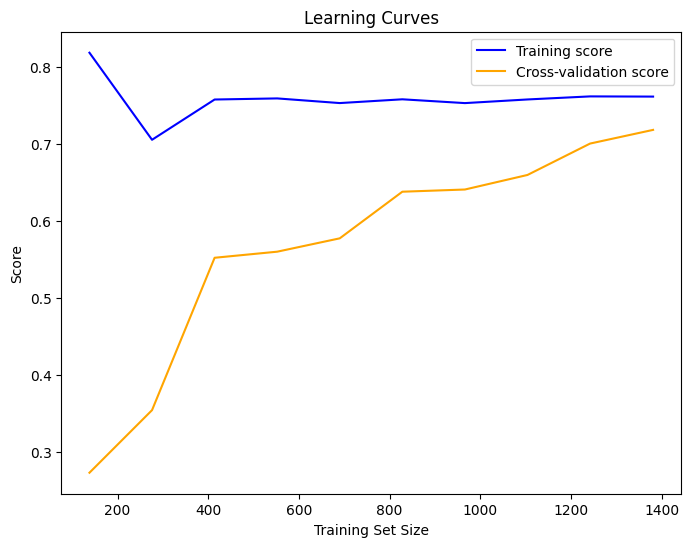

In [1541]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=estimator, X=X, y=y, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, color="blue", label="Training score")
    plt.plot(train_sizes, test_mean, color="orange", label="Cross-validation score")
    plt.title("Learning Curves")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Usage:
plot_learning_curve(sgd_regressor, X, y)


In [1542]:
# prediction function 
def new_prediction(values: list, features: list):
    prediction = {}

    for key, value in zip(features, values):
        prediction[key] = value

    return pd.DataFrame(prediction, index=[0])

In [1543]:
new_values = ['Hotel',84,335066,12000,1980,12379,'non_residential']
new_building = new_prediction(new_values, features)

In [1544]:
new_building

,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,YearBuilt,avg_floor_area,building_classification,PrimaryPropertyType_College/University
0,Hotel,84,335066,12000,1980,12379,non_residential


In [1545]:
# train model 
sgd_regressor.fit(X, y)
# Encode New Features
new_building[nan_features] = ordinal_encoder.transform(new_building[nan_features])

# Scale the New Features
new_building[numerical_features] = s_scaler.transform(new_building[numerical_features])

# Predict demmand
prediction = sgd_regressor.predict(new_building)
result = pd.DataFrame({'Prediction': int(prediction[0])},index=[0] )
result


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

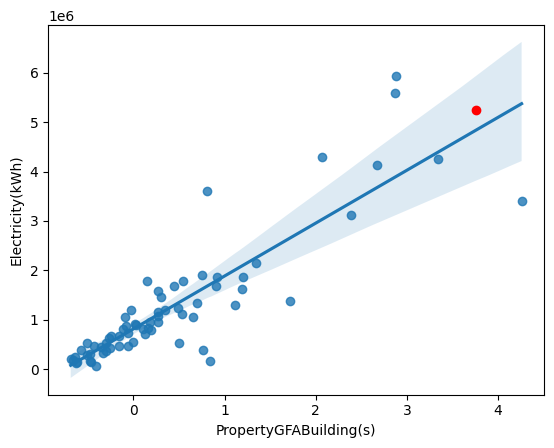

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

hotel_code = df_scaled.PrimaryPropertyType.unique()[0]

# Filter the data for a specific property type
property_type = hotel_code # Replace with the property type you want to visualize
subset_data = df_scaled[df_scaled['PrimaryPropertyType'] == property_type]

# Create a regression plot
sns.regplot(data=subset_data, x='PropertyGFABuilding(s)', y='Electricity(kWh)')

# Scatter plot for predicted values
plt.scatter(new_building['PropertyGFABuilding(s)'], prediction, color='red', label='Predicted')